In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 8)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [4]:
import urllib2
import datetime

import numpy  as np

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, QTable, Column, MaskedColumn
from astropy import table

In [5]:
import cython
%load_ext cython

In [6]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [7]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [184]:
def nmagy_flux_to_mag(flux):
    return (22.5 - 2.5*np.log10(flux).view(np.ma.masked_array))*u.mag

# Search for the Bricks corresponding to SAGA hosts

This is because the DR3 data release is not yet out so Risa needs to download the bricks from her proporietary access.

In [8]:
#pure-python version
def find_all_bricks(scs_to_match, bricktab):
    """
    Find all the DECALS bricks that get all of the skycoords in ``scs_to_match``
    """
    inras = []
    indecs = []
    bricks_to_include = np.zeros(len(bricktab), dtype=bool)
    ra1 = bricktab['RA1']
    ra2 = bricktab['RA2']
    dec1 = bricktab['DEC1']
    dec2 = bricktab['DEC2']
    for ra, dec in zip(scs_to_match.ra.deg, scs_to_match.dec.deg):
        inra = (ra1 < ra) & (ra < ra2)
        indec = (dec1 < dec) & (dec < dec2)
        inbrick = inra&indec
        #assert np.sum(inbrick) == 1
        bricks_to_include[inbrick] = True
    return bricks_to_include

In [9]:
%%cython

cimport cython
import numpy as np

def find_all_bricks(scs_to_match, bricktab):
    """
    Find all the DECALS bricks that get all of the skycoords in ``scs_to_match``
    """
    bricks_to_include = np.zeros(len(bricktab), dtype=np.dtype("i"))
    ra1 = np.array(bricktab['RA1']).astype('float64')
    ra2 = np.array(bricktab['RA2']).astype('float64')
    dec1 = np.array(bricktab['DEC1']).astype('float64')
    dec2 = np.array(bricktab['DEC2']).astype('float64')
    _find_all_innerloop(bricks_to_include, 
                        scs_to_match.ra.deg, scs_to_match.dec.deg, 
                        ra1, ra2, dec1, dec2)
    return bricks_to_include.astype(bool)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef void _find_all_innerloop(int[:] bricks_to_include, 
                              double[:]  ras, double[:]  decs, 
                              double[:]  ras1, double[:]  ras2, 
                              double[:]  decs1, double[:]  decs2):
    cdef size_t i, j
    cdef size_t ncoos = len(ras)
    cdef size_t nbricks = len(ras1)
    
    for i in range(ncoos):
        for j in range(nbricks):
            if ras1[j] < ras[i] < ras2[j] and decs1[j] < decs[i] < decs2[j]:
                bricks_to_include[j] = 1


In [42]:
def plot_bricks(bricktab):
    for brick in bricktab:
        ras = [brick['RA1'], brick['RA1'], brick['RA2'], brick['RA2'], brick['RA1']]
        decs = [brick['DEC1'], brick['DEC2'], brick['DEC2'], brick['DEC1'], brick['DEC1']]
        plt.plot(ras, decs)
        plt.text(brick['RA'], brick['DEC'], brick['BRICKNAME'], ha='center', va='center')

In [11]:
bricktab = Table.read('decals_catalogs/survey-bricks.fits.gz')

### Script to copy the bricks 

(From Risa:)
for reference the names of the files we need to copy are:

/scratch1/scratchdirs/desiproc/dr3/tractor/BRICKNUM/tractor-BRICKNAME.fits

where BRICKNUM is the first 3 digits of BRICKNAME

In [12]:
fromtempl = '/scratch1/scratchdirs/desiproc/dr3/tractor/{bricknamef3}/tractor-{brickname}.fits'

def generate_risa_script_lines(bricks, finalfn_base, write_file=False):
    """
    Generates a script that risa can use to copy over the necessary bricks
    """
    lines = []
    fns = []
    for bricknm in bricks['BRICKNAME']:
        fromfn = fromtempl.format(brickname=bricknm, bricknamef3=bricknm[:3])
        fns.append(os.path.split(fromfn)[-1])
        lines.append('scp edison.nersc.gov:{} .'.format(fromfn))

    lines.append('tar -cf {}.tar '.format(finalfn_base))
    lines.append('gzip {}.tar'.format(finalfn_base))
    
    fn = None
    if write_file:
        if write_file is True:
            fn = finalfn_base + '_decals_dl.sh'
        else:
            fn = os.path.join(write_file, finalfn_base + '_decals_dl.sh')
            
        with open(fn, 'w') as f:
            for l in lines:
                f.write(l)
                f.write('\n')
    
    return lines, fn

## Test w/ AnaK 

In [61]:
anak = hsd['AnaK']
anakscs = SkyCoord(anak.get_sdss_catalog()['ra'], 
                   anak.get_sdss_catalog()['dec'], 
                   unit=u.deg)

292.589471102 s


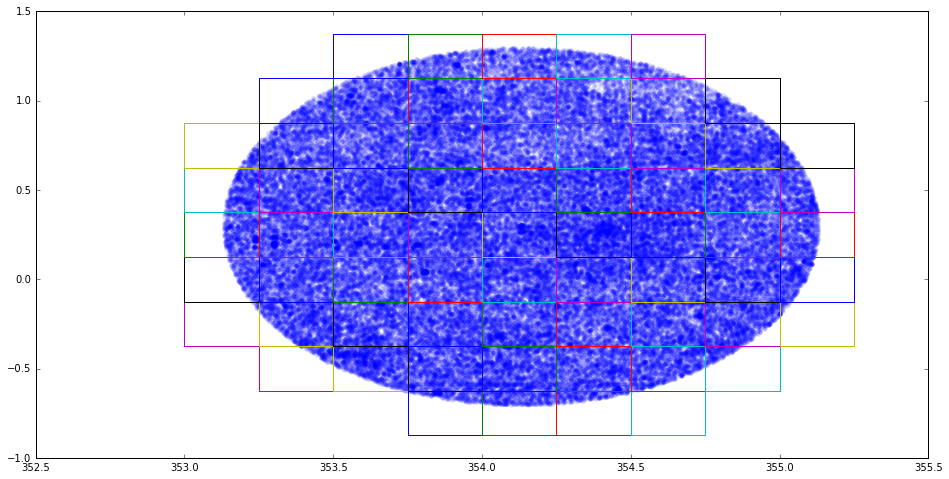

In [73]:
scs_to_search = anakscs[::25]
scs_to_search = scs_to_search[np.random.permutation(len(scs_to_search))]
scs_to_search = anakscs

st = time()
anak_brick_msk = find_all_bricks(scs_to_search, bricktab)
et = time()
print(et-st, 's')

plt.scatter(anakscs.ra, anakscs.dec, alpha=.15, lw=0)
plot_bricks(bricktab[anak_brick_msk])

In [152]:
generate_risa_script_lines(bricktab[anak_brick_msk], 'anak-bricks', write_file=True)
!cat anak-bricks_decals_dl.sh

scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2478p187.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/248/tractor-2481p187.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/248/tractor-2483p187.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2474p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2476p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2479p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/248/tractor-2482p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/248/tractor-2484p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/248/tractor-2487p190.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2472p192.fits .
scp edison.nersc.gov:/scratch1/scratchdirs/desiproc/dr3/tractor/247/tractor-2475

## Now try the whole shebang

In [13]:
named = 'Bandamanna, Dune, Gilgamesh, Odyssey, OBrother, AnaK, Catch22, Narnia'.split(', ')
nsas = [165082, 145398, 145729, 145879, 166141, 149977, 150578, 153017, 127226, 129237, 129387, 130133, 130625, 131531]

In [14]:
hostobjs = [hsd[nm] for nm in named]
for nsa in nsas:
    hostobjs.append(hosts.NSAHost(nsa))
    
for h in hostobjs:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [15]:
# make sure they can all load their catalogs
for ho in hostobjs:
    print(ho)
    cat = ho.get_sdss_catalog()

<hosts.NSAHost object w/ name 'Bandamanna' AKA: ['NGC7818', 'NSA126115']>
<hosts.NSAHost object w/ name 'Dune' AKA: ['NGC5750', 'NSA165536']>
<hosts.NSAHost object w/ name 'Gilgamesh' AKA: ['NGC5962', 'NSA166313']>
<hosts.NSAHost object w/ name 'Odyssey' AKA: ['NGC6181', 'NSA147100']>
<hosts.NSAHost object w/ name 'OBrother' AKA: ['NSA149781']>
<hosts.NSAHost object w/ name 'AnaK' AKA: ['NGC7716', 'NSA61945']>
<hosts.NSAHost object w/ name 'Catch22' AKA: ['NGC7541', 'NSA150887']>
<hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>
<hosts.NSAHost object w/ name 'NSA165082'>
<hosts.NSAHost object w/ name 'NSA145398'>
<hosts.NSAHost object w/ name 'NSA145729'>
<hosts.NSAHost object w/ name 'NSA145879'>
<hosts.NSAHost object w/ name 'NSA166141'>
<hosts.NSAHost object w/ name 'NSA149977'>
<hosts.NSAHost object w/ name 'NSA150578'>
<hosts.NSAHost object w/ name 'NSA153017'>
<hosts.NSAHost object w/ name 'NSA127226'>
<hosts.NSAHost object w/ name 'NSA129237'>
<hosts.NSAHost 

Bandamanna 62.9318871498 s
Dune 119.61194396 s
Gilgamesh 114.613766193 s
Odyssey 143.258332968 s
OBrother 105.579316854 s
AnaK 104.953556061 s
Catch22 90.9490599632 s
Narnia 81.522559166 s
NSA165082 88.5563349724 s
NSA145398 105.980362177 s
NSA145729 111.13717103 s
NSA145879 118.410391092 s
NSA166141 119.030681849 s
NSA149977 80.7785429955 s
NSA150578 77.1743168831 s
NSA153017 72.5930798054 s
NSA127226 66.6770560741 s
NSA129237 64.4723660946 s
NSA129387 77.6816520691 s
NSA130133 75.1966509819 s
NSA130625 74.5449619293 s
NSA131531 69.7502119541 s


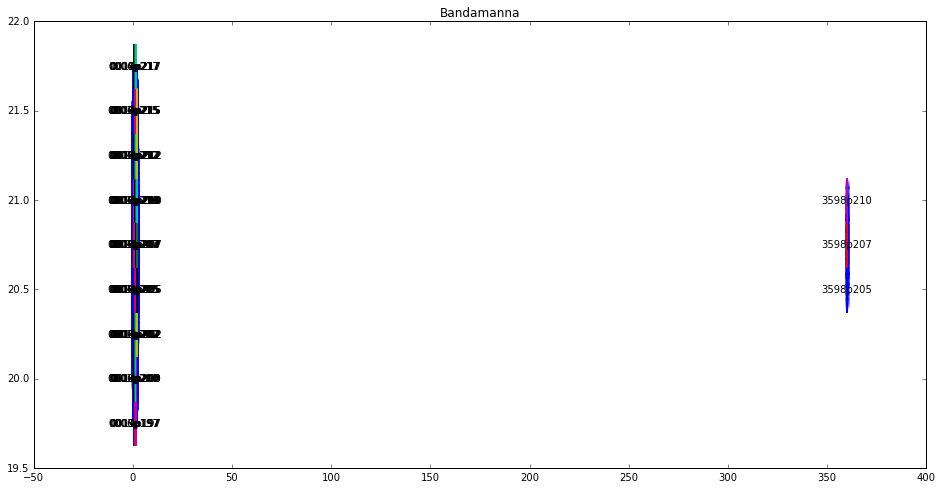

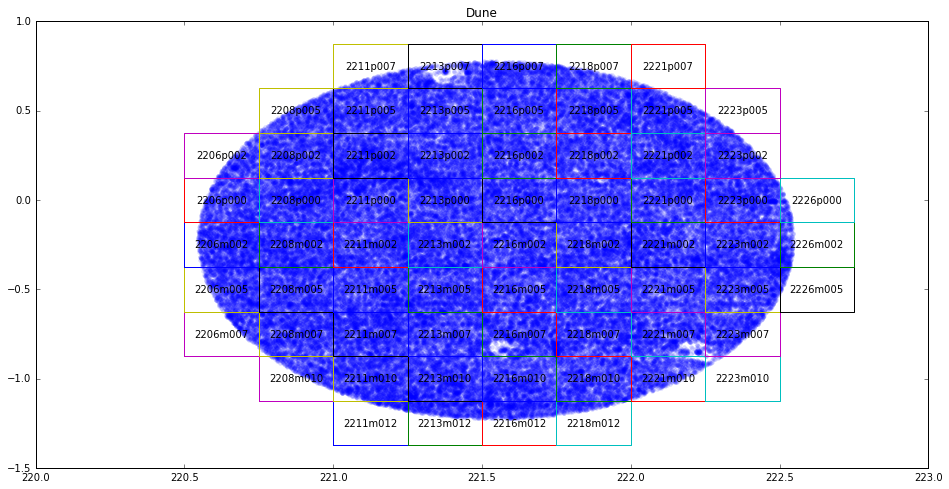

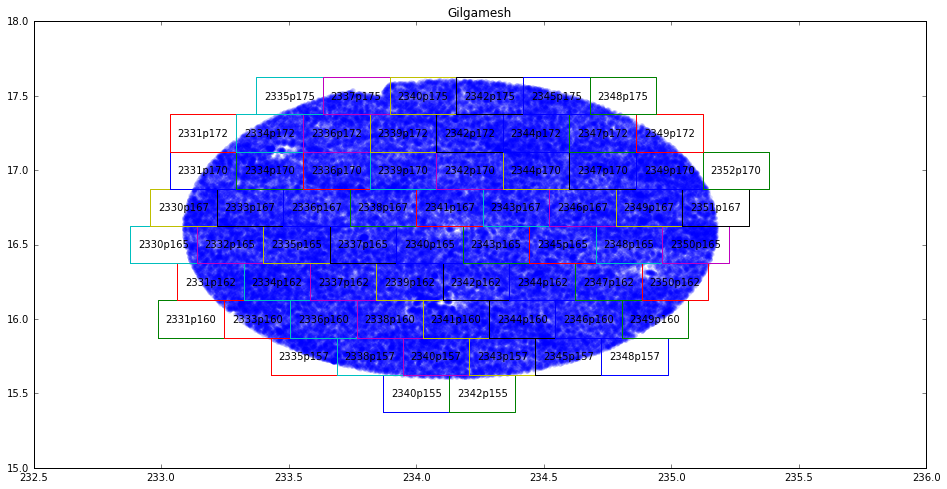

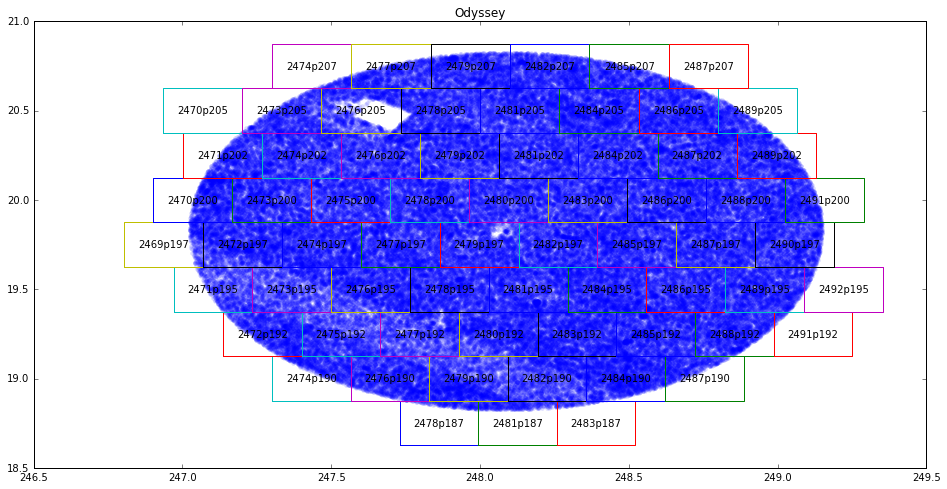

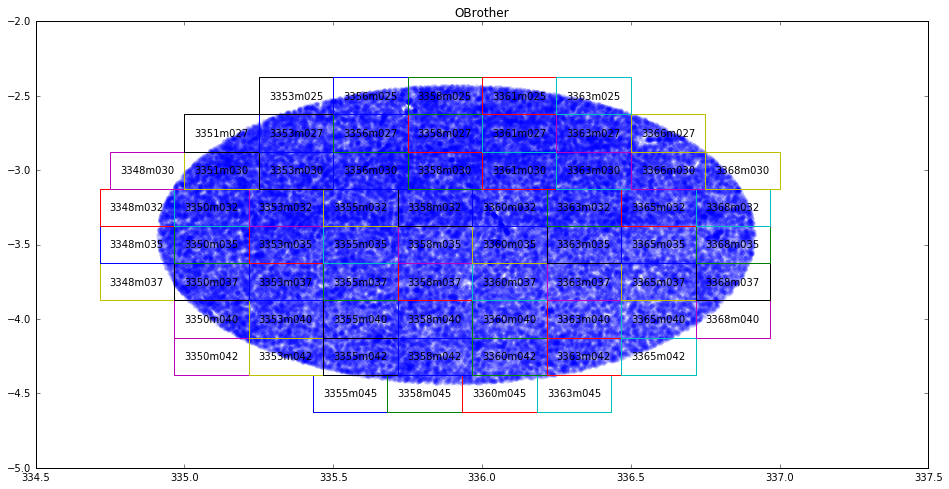

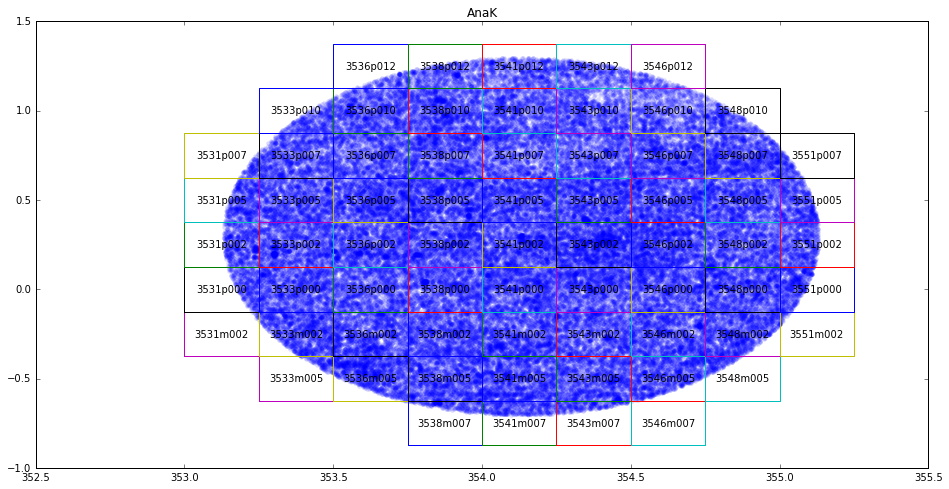

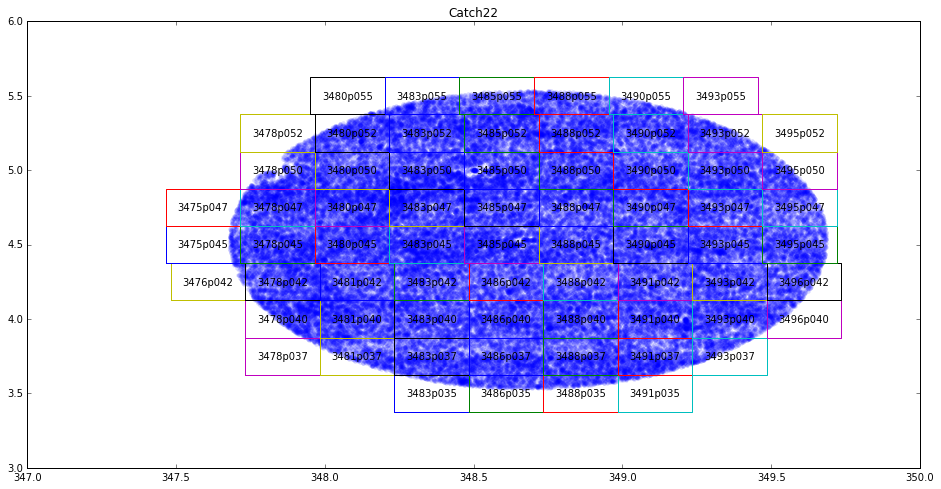

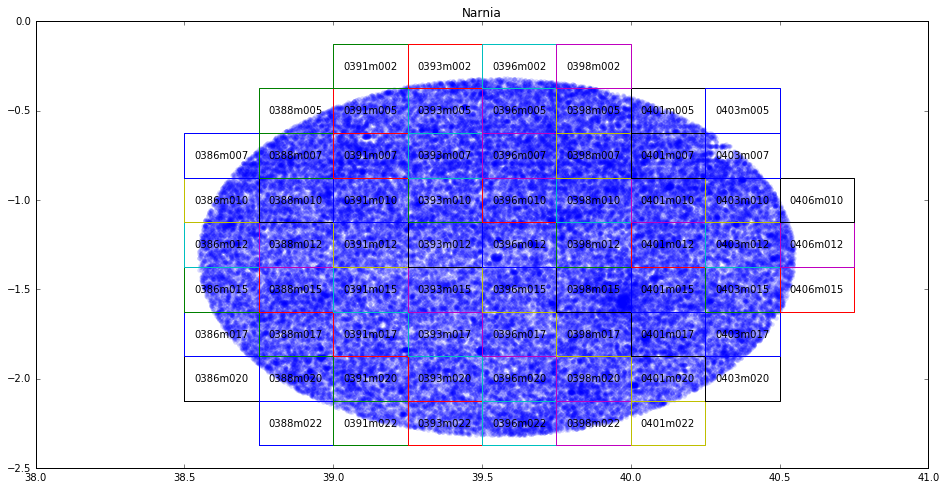

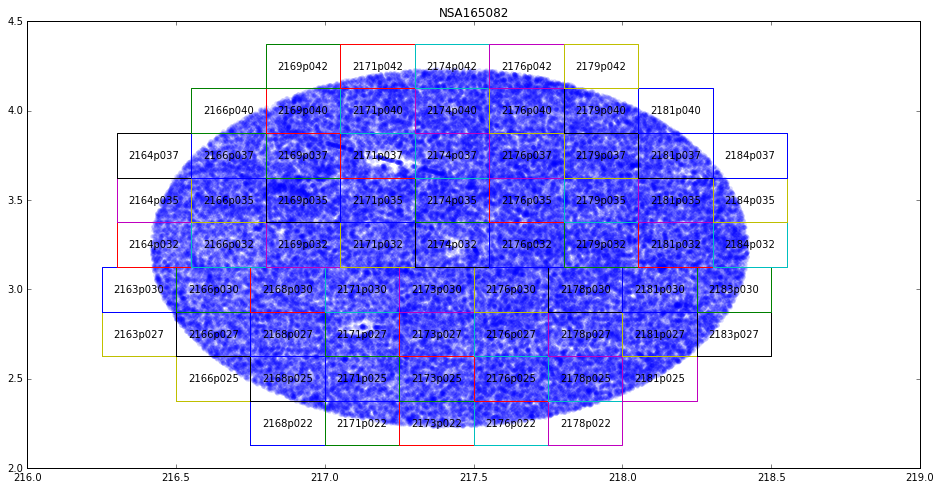

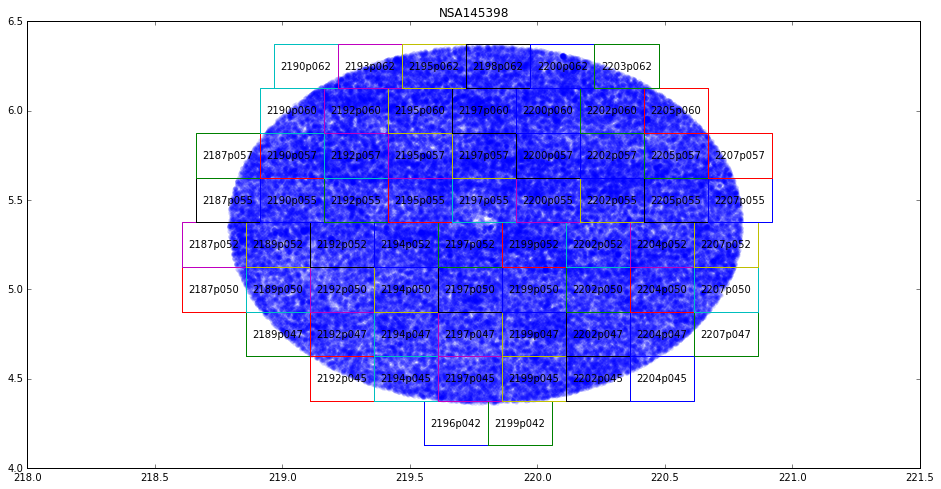

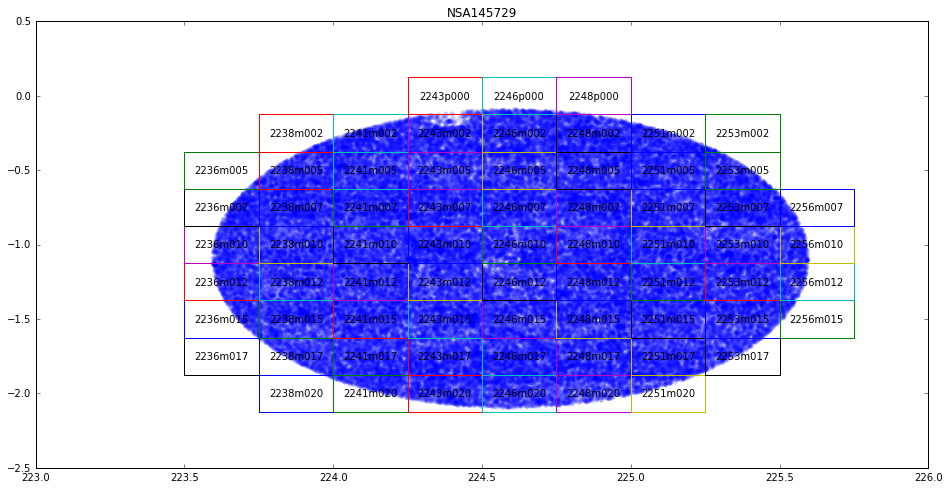

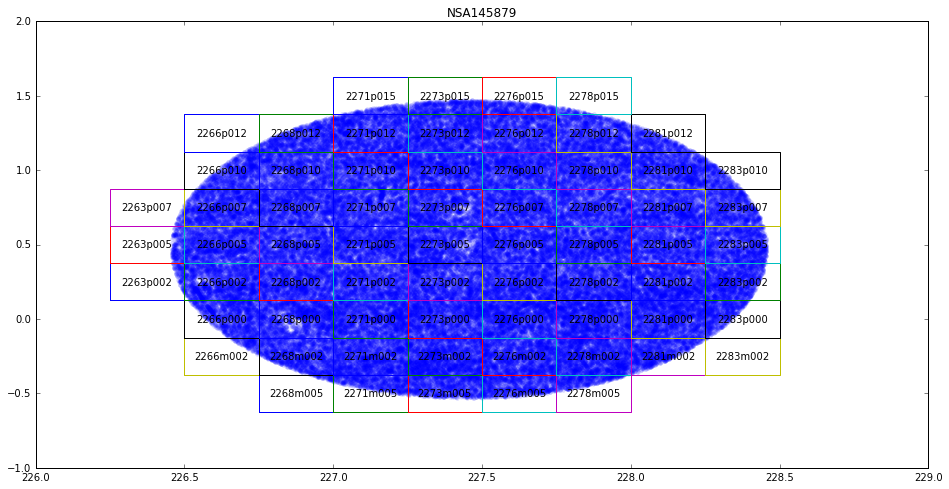

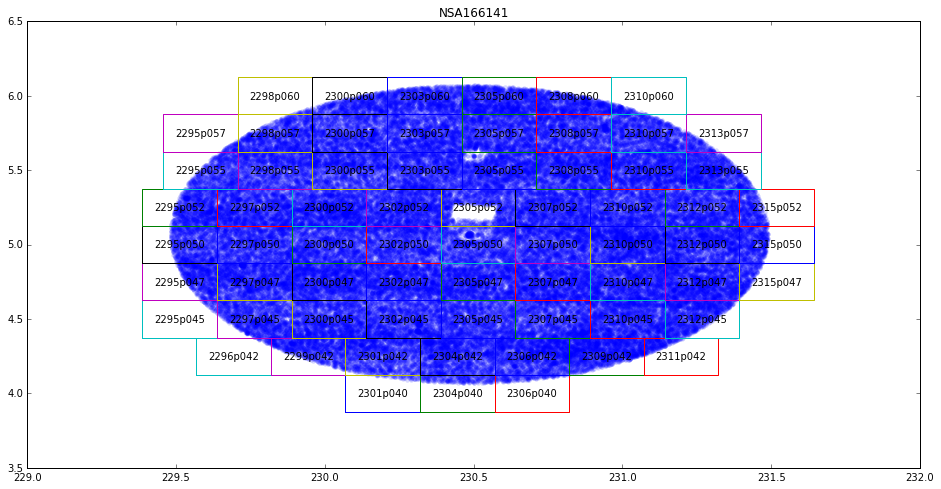

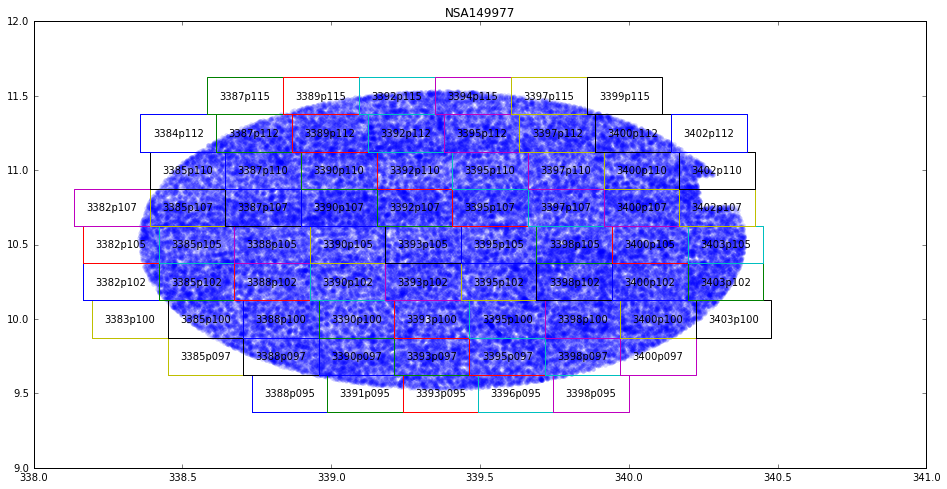

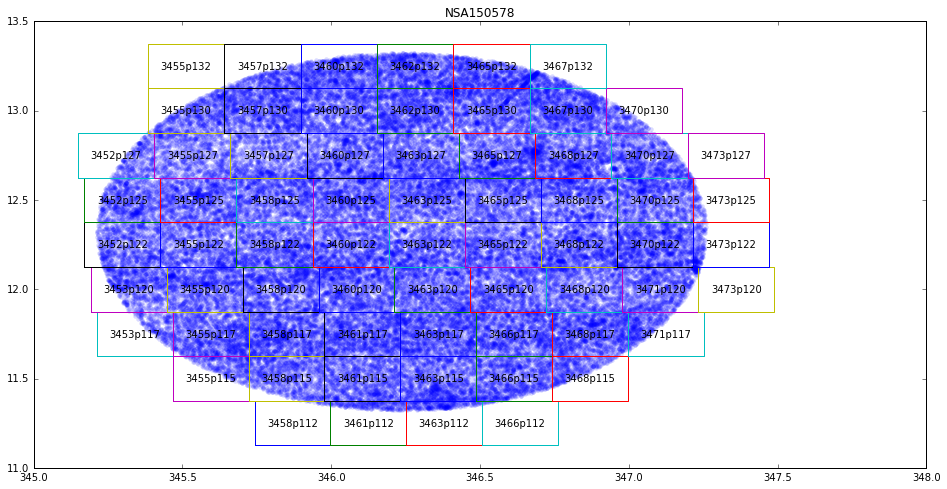

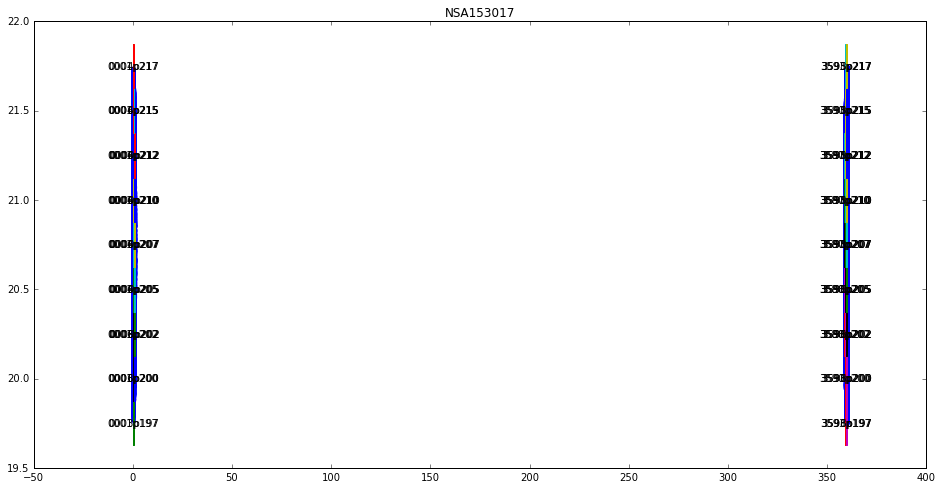

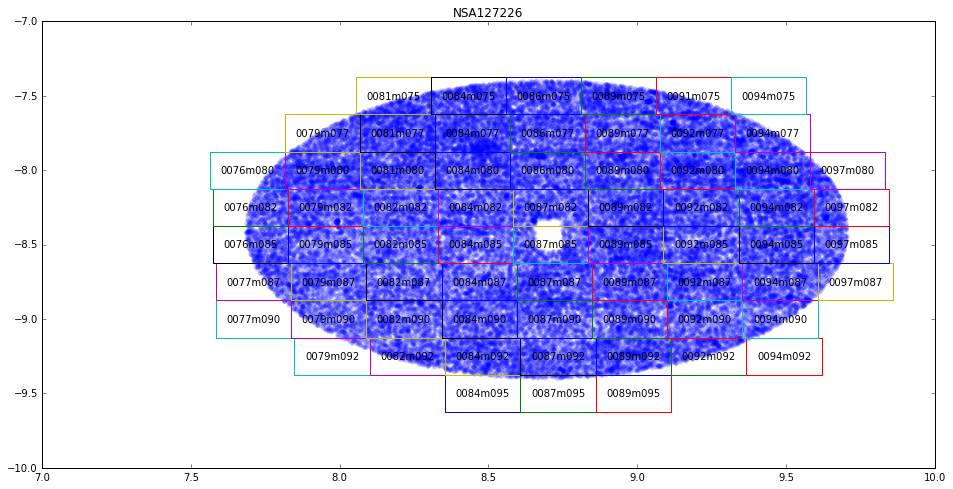

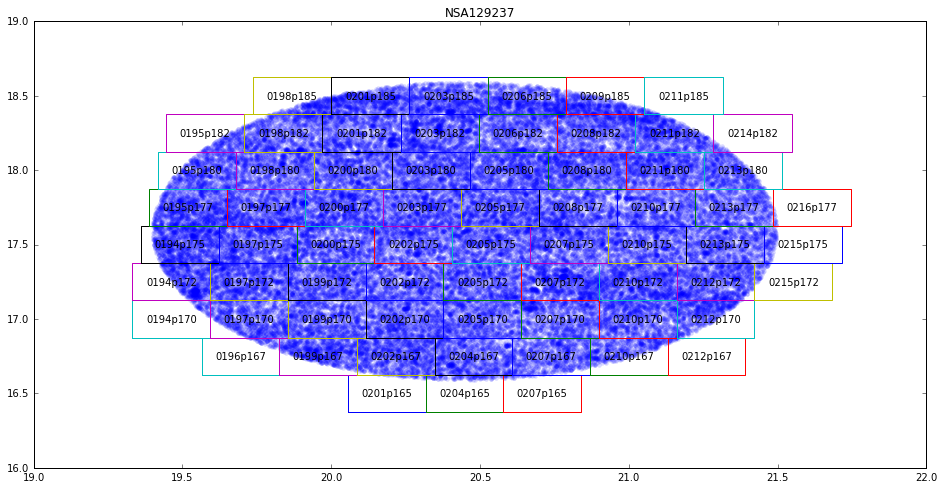

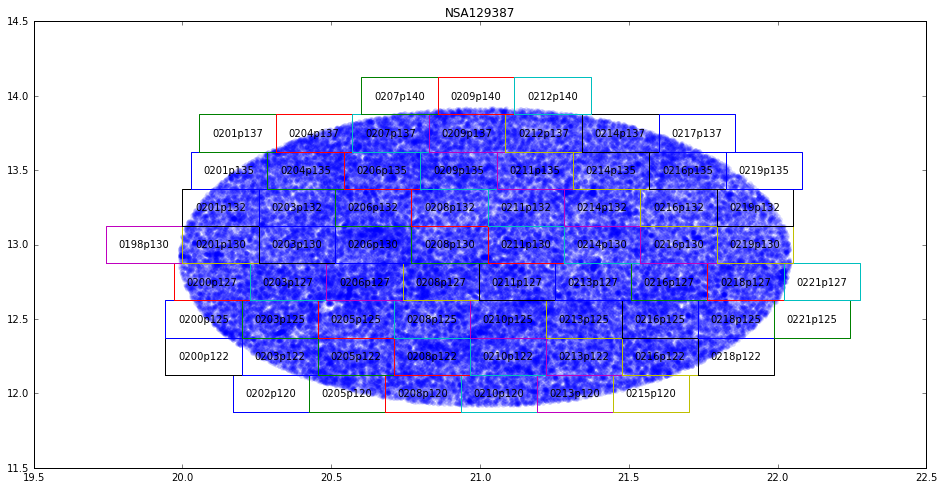

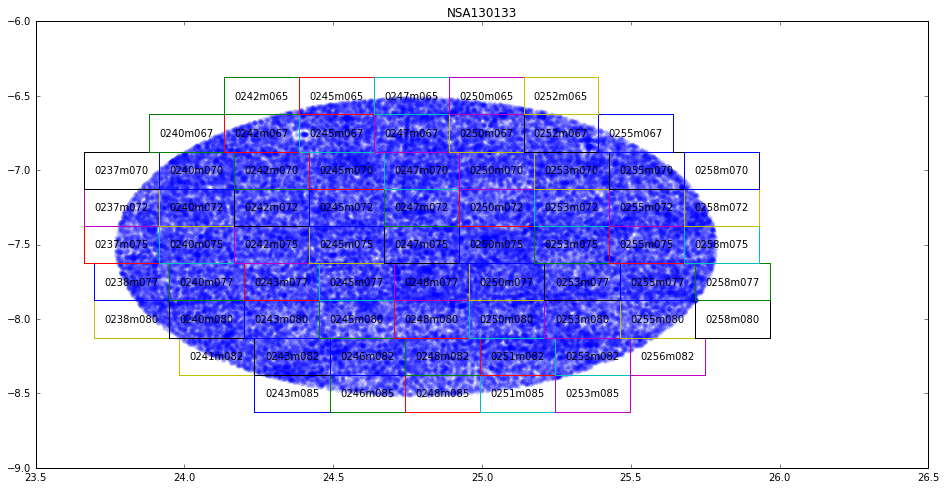

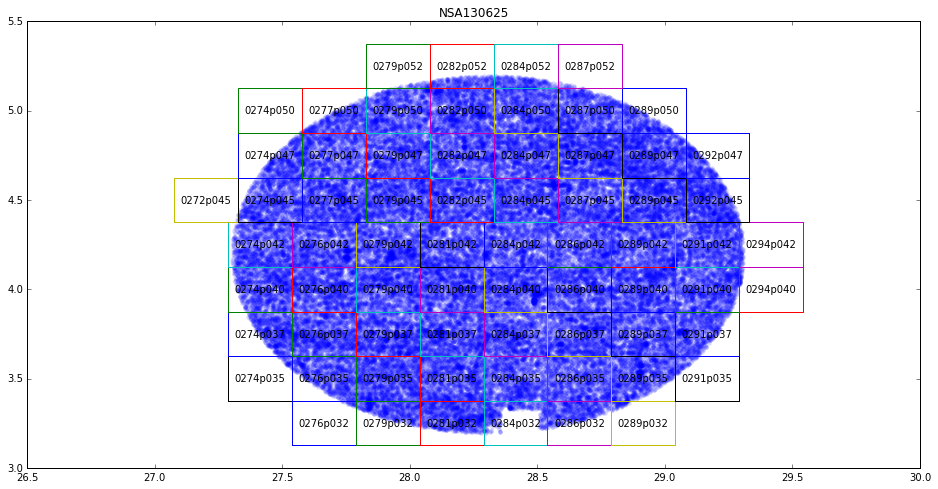

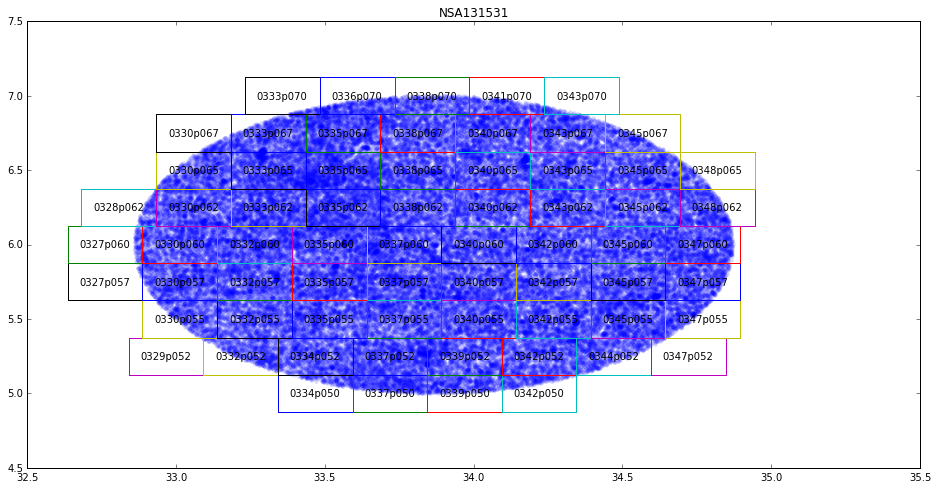

In [47]:
for h in hostobjs:
    htab = h.get_sdss_catalog()
    scs = SkyCoord(htab['ra'], htab['dec'], unit=u.deg)

    st = time()
    brick_msk = find_all_bricks(scs, bricktab)
    et = time()
    print(h.name, et-st, 's')
    
    outfn = generate_risa_script_lines(bricktab[brick_msk], 
                                       '{}-bricks'.format(h.name), 
                                       write_file='decals_catalogs')[1]
    !cp $outfn /Users/erik/Dropbox/scripts_for_risa

    plt.figure()
    plt.scatter(scs.ra, scs.dec, alpha=.15, lw=0)
    plot_bricks(bricktab[brick_msk])
    plt.title(h.name)
    plt.savefig('/Users/erik/Dropbox/scripts_for_risa/{}.png'.format(h.name))

# Now load the catalogs for AnaK, again as a test case

In [89]:
anak = hsd['AnaK']

In [52]:
anakbrickfns = !tar tf decals_catalogs/AnaK-bricks.tgz
anakbrickfns = ['decals_catalogs/'+fn for fn in anakbrickfns]

In [65]:
allbricks = txable.vstack([Table.read(fn) for fn in anakbrickfns])
decals_scs = SkyCoord(allbricks['ra'], allbricks['dec'])
allbricks

<Table masked=True length=433961>
brickid brickname objid ... shapeDev_e1_ivar shapeDev_e2 shapeDev_e2_ivar
                        ...                                              
 int32     str8   int32 ...     float32        float32       float32     
------- --------- ----- ... ---------------- ----------- ----------------
 330340  3531m002     0 ...              0.0         0.0              0.0
 330340  3531m002     1 ...              0.0         0.0              0.0
 330340  3531m002     2 ...              0.0         0.0              0.0
 330340  3531m002     3 ...              0.0         0.0              0.0
 330340  3531m002     4 ...              0.0         0.0              0.0
 330340  3531m002     5 ...              0.0         0.0              0.0
 330340  3531m002     6 ...              0.0         0.0              0.0
 330340  3531m002     7 ...              0.0         0.0              0.0
 330340  3531m002     8 ...              0.0         0.0              0.0
    ...       ...   ... ...              ...         ...              ...
 336108  3551p007  6109 ...              0.0         0.0              0.0
 336108  3551p007  6110 ...              0.0         0.0              0.0
 336108  3551p007  6111 ...              0.0         0.0              0.0
 336108  3551p007  6112 ...              0.0         0.0              0.0
 336108  3551p007  6113 ...              0.0         0.0              0.0
 336108  3551p007  6114 ...              0.0         0.0              0.0
 336108  3551p007  6115 ...              0.0         0.0              0.0
 336108  3551p007  6116 ...              0.0         0.0              0.0
 336108  3551p007  6117 ...              0.0         0.0              0.0
 336108  3551p007  6118 ...              0.0         0.0              0.0

## Checking out one specific object that seems to be a satellite from SDSS

In [79]:
seps = SkyCoord(353.77881, 0.30106, unit=u.deg).separation(decals_scs)
sorti = np.argsort(seps)
print(seps[sorti[:2]].to(u.arcsec))
allbricks[sorti[:2]]

[u'0.104814arcsec' u'4.17148arcsec']


<Table masked=True length=2>
brickid brickname objid ... shapeDev_e1_ivar shapeDev_e2 shapeDev_e2_ivar
                        ...                                              
 int32     str8   int32 ...     float32        float32       float32     
------- --------- ----- ... ---------------- ----------- ----------------
 333223  3538p002  4538 ...              0.0         0.0              0.0
 333223  3538p002  4540 ...              0.0         0.0              0.0

In [87]:
22.5 - 2.5*np.log10(allbricks[sorti[:2]]['decam_flux']).view(np.ma.masked_array)

-c:1: RuntimeWarning: divide by zero encountered in log10


masked_BaseColumn(data =
 [[-- 22.659645080566406 21.449073791503906 -- 20.747966766357422 --]
 [-- 22.798818588256836 22.152584075927734 -- 21.067115783691406 --]],
                  mask =
 [[ True False False  True False  True]
 [ True False False  True False  True]],
            fill_value = 1.0)

## More general comparisons with SDSS 

In [179]:
sdsscat = anak.get_sdss_catalog()
sdss_scs = SkyCoord(sdsscat['RA'], sdsscat['DEC'], unit=u.deg)

In [180]:
idx, d2d, _ = sdss_scs.match_to_catalog_sky(decals_scs)

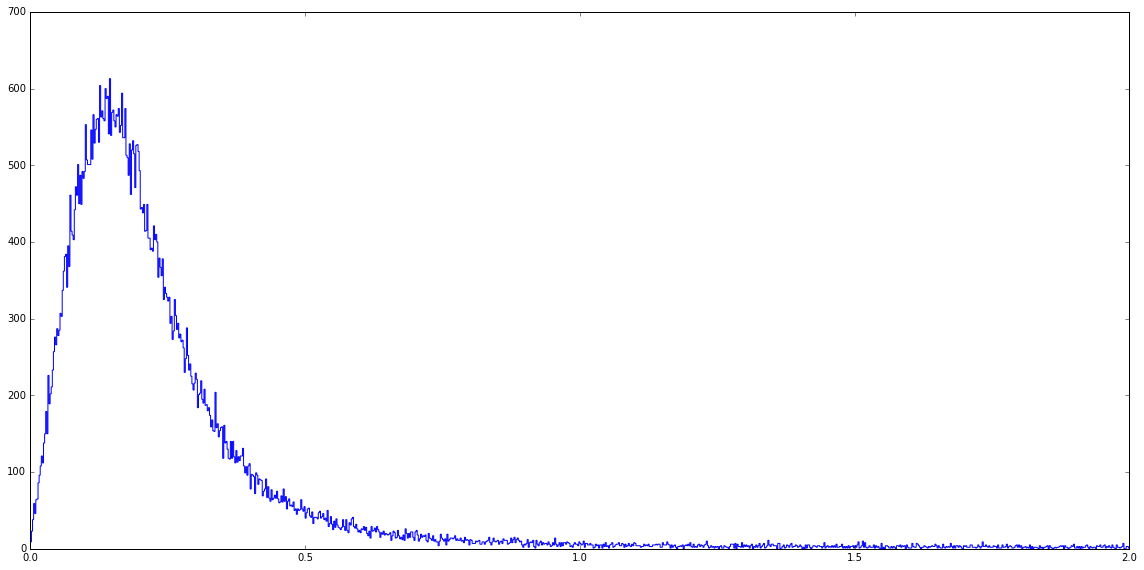

In [181]:
plt.hist(d2d.arcsec,bins=1000, range=(0,2), histtype='step')
plt.tight_layout()

In [186]:
# this is a bit conservative, but purity>completeness
matches = d2d < 0.3*u.arcsec

matched_sdss = sdsscat[matches]
matched_decals = allbricks[idx[matches]]

matched_decals_mags = nmagy_flux_to_mag(matched_decals['decam_flux'])
matched_decals_g = matched_decals_mags[:,1]
matched_decals_r = matched_decals_mags[:,2]
matched_decals_z = matched_decals_mags[:,4]

-c:2: RuntimeWarning: divide by zero encountered in log10
-c:2: RuntimeWarning: invalid value encountered in log10


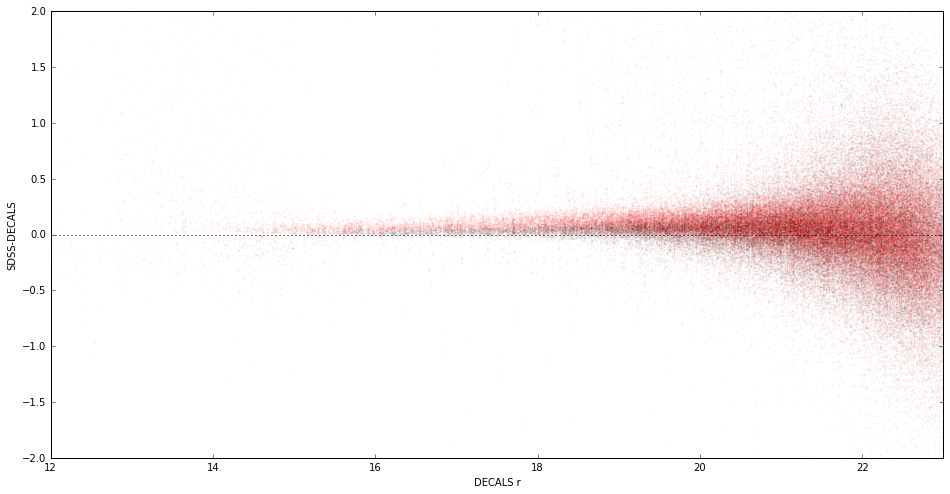

In [187]:
dg = matched_sdss['g']*u.mag - matched_decals_g
dr = matched_sdss['r']*u.mag - matched_decals_r
dz = matched_sdss['z']*u.mag - matched_decals_z

sckwargs = dict(lw=0, s=3, alpha=.05)
plt.scatter(matched_decals_r, dg, c='r', **sckwargs)
plt.scatter(matched_decals_r, dr, c='r',**sckwargs)
plt.scatter(matched_decals_r, dz, c='k', **sckwargs)

plt.axhline(0, color='k', ls=':')

plt.xlim(12,23)
plt.ylim(-2, 2)
plt.xlabel('DECALS r')
plt.ylabel('SDSS-DECALS')

## Specific comparisons of "bad" objects from SDSS 

Here are the P_ML > 0.1 objects in AnaK.   These are sorted on
zquality:  the first two objects have not been targeted (zq=-1), the
next 4 objects were targted but did not measure a redshift (zq=1).
Note that these all have r_err > 0.1.

I suggest putting this list into SDSS Navigate to give you a better
sense of these failures.

In [208]:
data = """
    r_err                 RA                   Dec          r_mag    zquality

    0.100777       353.94856      0.38954233      17.7467   -1
    0.0699525       354.00201     0.084751088      17.0503   -1
     0.126755       354.08257     0.060601196      17.8210   1
     0.138982       354.07164     0.039664411      17.8468   1
     0.211444       353.78034     0.016203257      20.3697   1
     0.119890       354.14926      0.32713565      17.7556   1
    0.0251430       354.01042      0.56803290      17.5909   4
    0.0117326       354.19523      0.62342377      15.7093   4
   0.00874042       353.98570      0.70387257      16.1683   4
   0.00154292       354.13105      0.29726505      11.3966   4
   """[1:-1]
failures_tab = Table.read(data, format='ascii')

In [194]:
print(targeting.sampled_imagelist(failures_tab['RA'], failures_tab['Dec']))
# can also be used for Yao's viewer at http://www.slac.stanford.edu/~yymao/saga/image-list-tool/

name ra dec
0 353.94856 0.38954233
1 354.00201 0.084751088
2 354.08257 0.060601196
3 354.07164 0.039664411
4 353.78034 0.016203257
5 354.14926 0.32713565
6 354.01042 0.5680329
7 354.19523 0.62342377
8 353.9857 0.70387257
9 354.13105 0.29726505


In [209]:
failures_sc = SkyCoord(failures_tab['RA'], failures_tab['Dec'], unit=u.deg)

In [210]:
idx_sdss, d2d_sdss, _ = failures_sc.match_to_catalog_sky(sdss_scs)
failures_tab['SDSS_offset'] = d2d_sdss.to(u.arcsec)
d2d_sdss.arcsec

array([ 0.00458799,  0.0014929 ,  0.01257544,  0.00988546,  0.0074604 ,
        0.01422832,  0.014211  ,  0.00094877,  0.00067798,  0.01450821])

In [211]:
idx_decals, d2d_decals, _ = failures_sc.match_to_catalog_sky(decals_scs)
failures_tab['DECALS_offset'] = d2d_decals.to(u.arcsec)
d2d_decals.arcsec

array([ 0.1973395 ,  0.13132402,  0.18287091,  0.66298091,  5.99867319,
        0.12780086,  0.78696739,  0.52710998,  0.14172156,  0.4706275 ])

Curiosly, the DECALS matches tend to have centroids quite a bit off

In [212]:
decals_mags = nmagy_flux_to_mag(allbricks[idx_decals]['decam_flux'])

failures_tab['DECALS_g'] = decals_mags[:, 1]
failures_tab['SDSS_g'] = sdsscat[idx_sdss]['g']*u.mag
failures_tab['dg'] = failures_tab['SDSS_g'] - failures_tab['DECALS_g']

failures_tab['DECALS_r'] = decals_mags[:, 2]
failures_tab['SDSS_r'] = sdsscat[idx_sdss]['r']*u.mag
failures_tab['dr'] = failures_tab['SDSS_r'] - failures_tab['DECALS_r']

failures_tab['DECALS_z'] = decals_mags[:, 4]
failures_tab['SDSS_z'] = sdsscat[idx_sdss]['z']*u.mag
failures_tab['dz'] = failures_tab['SDSS_z'] - failures_tab['DECALS_z']

failures_tab

-c:2: RuntimeWarning: divide by zero encountered in log10


<Table length=10>
  r_err        RA        Dec      r_mag  ... DECALS_z  SDSS_z     dz   
                                         ...   mag      mag      mag   
 float64    float64    float64   float64 ... float32  float32  float32 
---------- --------- ----------- ------- ... -------- ------- ---------
  0.100777 353.94856  0.38954233 17.7467 ...  22.2525 17.0633  -5.18915
 0.0699525 354.00201 0.084751088 17.0503 ...  22.5177 17.5281  -4.98959
  0.126755 354.08257 0.060601196  17.821 ...  21.3404 17.6484  -3.69201
  0.138982 354.07164 0.039664411 17.8468 ...  20.9506 17.2359  -3.71471
  0.211444 353.78034 0.016203257 20.3697 ...  21.6323 26.5084   4.87614
   0.11989 354.14926  0.32713565 17.7556 ...  21.4536 16.6073  -4.84629
  0.025143 354.01042   0.5680329 17.5909 ...  17.5279 17.2869 -0.241018
 0.0117326 354.19523  0.62342377 15.7093 ...  19.5976 15.3143  -4.28331
0.00874042  353.9857  0.70387257 16.1683 ...  17.5482 15.8416  -1.70654
0.00154292 354.13105  0.29726505 11.3966 ...  13.4828 10.6397  -2.84312